In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [3]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [4]:
def reframe_datasets(training, testing):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/24))
	test = array(np.split(testing, len(testing)/24))
	
	return train, test

In [5]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [6]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [7]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 300, 24
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(400, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [8]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next day
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [30]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler):

	# history is a list of daily data
	history = [x for x in train]

	# walk-forward validation over each day
	predictions = list()

	for i in range(len(test)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history.append(test[i, :])

	# evaluate predictions hours for each day
	predictions = array(predictions)

	print(np.shape(predictions))

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, 1)
	predictions_reshaped = scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, 1)

	# Reshape `test` before inverse transform

	print(np.shape(test))

	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)		
	
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, score, scores

# Energy Demand Prediction
A sample dataset was acquired from Keggle to test the LSTM model on energy demand data. The energy demands of years 2015 and 2016 in Spain was taken to predict the energy demands of 2017.

In [10]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("energy_dataset.csv", engine='python')
df_energy = pd.DataFrame(dataset)

In [11]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [12]:
df_energy['time'] = df_energy['time'].str.replace('+01:00', '')
df_energy['time'] = df_energy['time'].str.replace('+02:00', '')
df_energy['time'] = df_energy['time'].str.replace(' ', '')
df_energy['time'] = df_energy['time'].str.replace(':', '')
df_energy['time'] = df_energy['time'].str.replace('-', '')

In [13]:
df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y%m%d%H%M%S', infer_datetime_format=True)
df_energy = df_energy.set_index(['time'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\2487084013.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y%m%d%H%M%S', infer_datetime_format=True)


In [14]:
print(df_energy.columns)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\1941729268.py:23: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


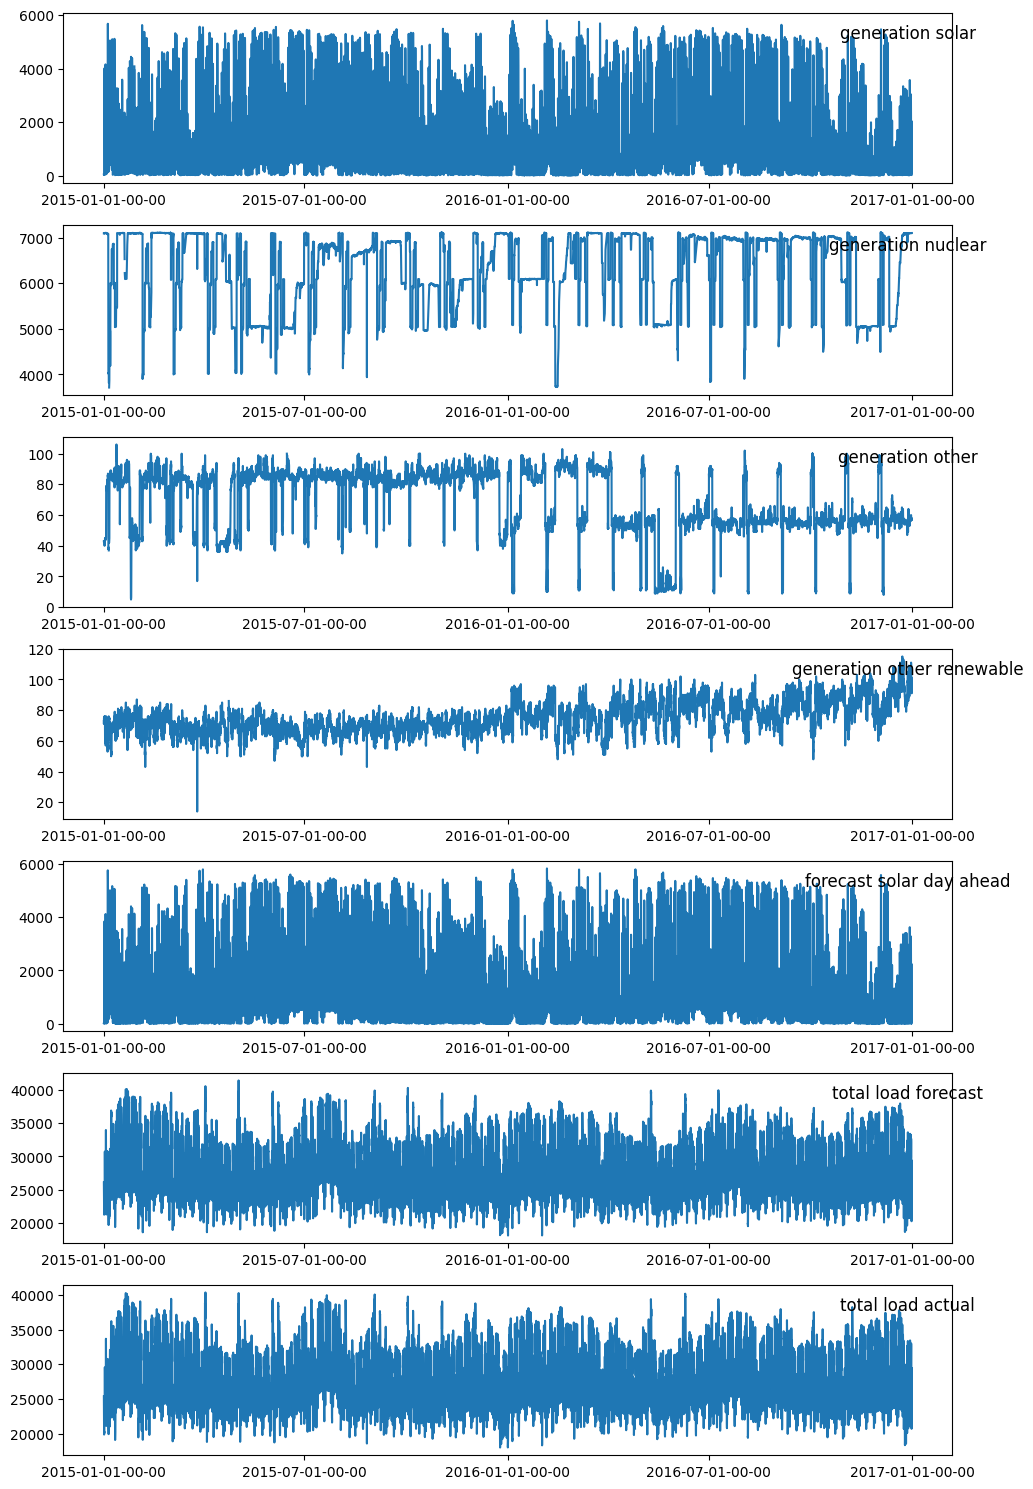

In [15]:
# Creating separate subplots for each series
values = df_energy[0:17532].values
dates = df_energy[0:17532].index  # Get the datetime index

# Specify columns to plot
groups = ['generation solar', 'generation nuclear', 'generation other',
          'generation other renewable', 'forecast solar day ahead', 'total load forecast', 'total load actual',]
i = 1

plt.figure(figsize=(10, 15))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates, values[:, df_energy.columns.get_loc(group)])  # Use datetime index on x-axis
    plt.title(df_energy.columns[df_energy.columns.get_loc(group)], y=0.8, x=0.95)

    # Set major x-axis locator to show only 4 dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=5))  # Force 4 labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'

    i += 1

plt.tight_layout()
plt.show()

In [16]:
df_2015_2016 = df_energy[0:17544]
df_2017 = df_energy[17544:26304]

df_2015_2016_Solar = df_2015_2016.iloc[:, df_2015_2016.columns.get_loc('generation solar')]

print(df_2015_2016_Solar.head())

df_2017_Solar = df_2017.iloc[:, df_2017.columns.get_loc('generation solar')]

print(df_2017_Solar.head())

time
2015-01-01 00:00:00    49.0
2015-01-01 01:00:00    50.0
2015-01-01 02:00:00    50.0
2015-01-01 03:00:00    50.0
2015-01-01 04:00:00    42.0
Name: generation solar, dtype: float64
time
2017-01-01 00:00:00    30.0
2017-01-01 01:00:00    30.0
2017-01-01 02:00:00    50.0
2017-01-01 03:00:00    87.0
2017-01-01 04:00:00    92.0
Name: generation solar, dtype: float64


In [17]:
# resample data to daily
hourly_groups = df_2015_2016_Solar.resample('H')
hourly_data_training = hourly_groups.sum()

# summarize
print(hourly_data_training.shape)
print(hourly_data_training.head())

# resample data to daily
hourly_groups_testing = df_2017_Solar.resample('H')
hourly_data_testing = hourly_groups_testing.sum()

# summarize
print(hourly_data_testing.shape)
print(hourly_data_testing.head())

(17544,)
time
2015-01-01 00:00:00    49.0
2015-01-01 01:00:00    50.0
2015-01-01 02:00:00    50.0
2015-01-01 03:00:00    50.0
2015-01-01 04:00:00    42.0
Freq: h, Name: generation solar, dtype: float64
(8760,)
time
2017-01-01 00:00:00    30.0
2017-01-01 01:00:00    30.0
2017-01-01 02:00:00    50.0
2017-01-01 03:00:00    87.0
2017-01-01 04:00:00    92.0
Freq: h, Name: generation solar, dtype: float64


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\101138927.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = df_2015_2016_Solar.resample('H')
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\101138927.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups_testing = df_2017_Solar.resample('H')


In [18]:
# save
hourly_data_training.to_csv('Hourly_Solar_Energy_Demand_Training_Paralel.csv')
hourly_data_testing.to_csv('Hourly_Solar_Energy_Demand_Testing_Paralel.csv')

In [19]:
# load the new file
dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(731, 24, 1)
0.008459945 0.0051795584
(365, 24, 1)
0.005285412 0.0015856236


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\2866548709.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\2866548709.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])


In [20]:
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

In [34]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 300, 72
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [35]:
# load the new file
dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 24
model = build_model(train, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\1493450586.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\1493450586.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing_Paralel.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
d:\Users

Epoch 1/300
244/244 - 20s - 84ms/step - loss: 0.0367
Epoch 2/300
244/244 - 17s - 68ms/step - loss: 0.0184
Epoch 3/300
244/244 - 17s - 69ms/step - loss: 0.0168
Epoch 4/300
244/244 - 17s - 68ms/step - loss: 0.0159
Epoch 5/300
244/244 - 17s - 68ms/step - loss: 0.0152
Epoch 6/300
244/244 - 17s - 68ms/step - loss: 0.0146
Epoch 7/300
244/244 - 17s - 68ms/step - loss: 0.0143
Epoch 8/300
244/244 - 17s - 68ms/step - loss: 0.0139
Epoch 9/300
244/244 - 17s - 68ms/step - loss: 0.0136
Epoch 10/300
244/244 - 17s - 68ms/step - loss: 0.0133
Epoch 11/300
244/244 - 17s - 68ms/step - loss: 0.0130
Epoch 12/300
244/244 - 17s - 68ms/step - loss: 0.0129
Epoch 13/300
244/244 - 17s - 68ms/step - loss: 0.0126
Epoch 14/300
244/244 - 17s - 68ms/step - loss: 0.0126
Epoch 15/300
244/244 - 17s - 68ms/step - loss: 0.0124
Epoch 16/300
244/244 - 17s - 68ms/step - loss: 0.0123
Epoch 17/300
244/244 - 17s - 68ms/step - loss: 0.0122
Epoch 18/300
244/244 - 17s - 68ms/step - loss: 0.0121
Epoch 19/300
244/244 - 17s - 69ms/ste

(365, 24)
(365, 24, 1)
[[[ 83.334206 ]
  [167.97748  ]
  [133.97856  ]
  ...
  [  4.0886755]
  [ -7.3604445]
  [ 42.071747 ]]

 [[ 72.36169  ]
  [ 63.657513 ]
  [ 16.565092 ]
  ...
  [130.50232  ]
  [155.58243  ]
  [200.63983  ]]

 [[ 89.160446 ]
  [ 84.827446 ]
  [ 78.03142  ]
  ...
  [162.41931  ]
  [ 52.07334  ]
  [ 42.748337 ]]

 ...

 [[ 27.584656 ]
  [ 41.476227 ]
  [ 24.259518 ]
  ...
  [ 77.182434 ]
  [ 58.73897  ]
  [ 57.887154 ]]

 [[ 14.72958  ]
  [ 19.61981  ]
  [ -2.444037 ]
  ...
  [107.50265  ]
  [ 97.841194 ]
  [100.835205 ]]

 [[125.657555 ]
  [173.08688  ]
  [170.38     ]
  ...
  [299.16922  ]
  [377.92752  ]
  [335.48578  ]]]
lstm: [864.777] 195.1, 212.0, 209.5, 206.6, 202.8, 177.8, 132.2, 124.7, 339.0, 745.5, 1124.6, 1298.0, 1337.3, 1344.0, 1362.3, 1381.7, 1387.2, 1345.7, 1221.5, 946.5, 566.6, 336.4, 268.8, 250.9


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_4920\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


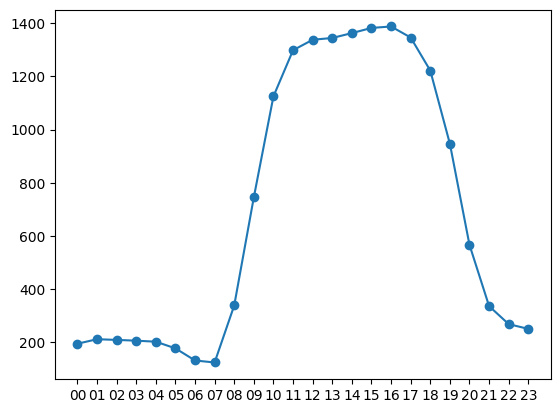

In [36]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

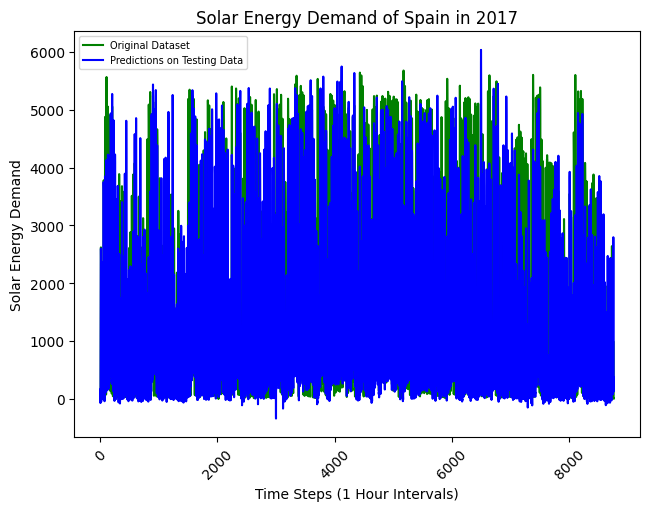

In [37]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing.values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Energy Demand')
plt.title('Solar Energy Demand of Spain in 2017')
plt.show()

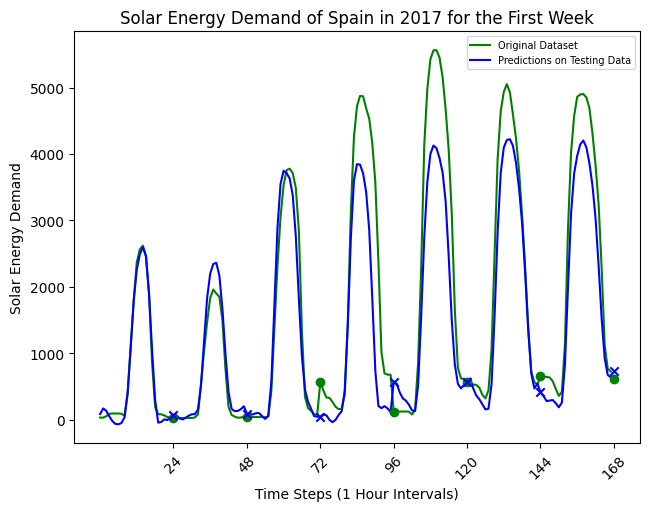

In [38]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing.values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing.values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Energy Demand')
plt.title('Solar Energy Demand of Spain in 2017 for the First Week')
plt.show()